<a href="https://colab.research.google.com/github/eirik-dn/NLP_project/blob/main/NLP_github_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
folder_path = '/content/my_project'

In [ ]:
!pip install transformers datasets nltk nlpaug scikit-learn torch seaborn pdfplumber pdfminer.six linearmodels swifter
!pip uninstall -y numpy gensim scipy smart-open
!pip install numpy==1.25.2 scipy gensim smart-open

Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Successfully uninstalled numpy-1.25.2
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
Found existing installation: smart-open 7.1.0
Uninstalling smart-open-7.1.0:
  Successfully uninstalled smart-open-7.1.0
  Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinu

In [ ]:

# Core packages
import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# NLTK for text preprocessing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import ngrams

# spacy for text preprocessing
import spacy

# Sklearn for vectorization, similarity metrics, clustering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Gensim for word embeddings
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec, KeyedVectors, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess

# Statsmodels for statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf

# swifter
import swifter




In [ ]:
# @title Load the textual data for the Earnings Calls of S&P500 from 2015 to 2021
import pandas as pd

# Load the Sample of Earnings Calls for the S&P500 from 2015 to 2021 with financials
Sample_EC = pd.read_csv("https://www.dropbox.com/scl/fi/2p7ahxroqj9pwf98ni5an/Sample_Calls.csv?rlkey=zfieicvz891u4e3z0aroeg0u7&dl=1")

# Load the Sample's Presentation texts
Sample_Presentations = pd.read_feather("https://www.dropbox.com/scl/fi/uceh2xva5g4apbmt92cgt/Sample_Calls_Presentations.feather?rlkey=ln4nzsa4nenqyvm0pg2cur9sp&dl=1")

# Load the Q&A session textual data for the sample
Sample_QAs = pd.read_feather("https://www.dropbox.com/scl/fi/iq4111nlmsykp2tzxk9xg/Sample_Calls_QA.feather?rlkey=xabjqmwhesx05jivrlfzkgj6m&dl=1")


## Note: column "file_name" is to be used for the merging

# ## Columns:
#     # Identifiers
#     "GVKEY": "A unique company identifier used by Compustat.",
#     "date_rdq": "The reporting date of the quarterly earnings or a related key event date.",
#     "co_conm": "The company’s name in CRSP.",

#     # Earnings Call Columns
#     "file_name": "The identifier or filename of the earnings call transcript.",
#     "CAR-11-Carhart": "Cumulative Abnormal Return over an event window using the Carhart 4-factor model.",
#     "CAR-11-ff3": "Cumulative Abnormal Return over an event window using the Fama-French 3-factor model.",
#     "CAR01-Carhart": "Cumulative Abnormal Return (alternative window) using the Carhart 4-factor model.",
#     "CAR01-ff3": "Cumulative Abnormal Return (alternative window) using the Fama-French 3-factor model.",
#     "IV": "Implied volatility (often from options) reflecting expected future stock price volatility.",
#     "hvol": "Historical volatility of the stock, based on past price movements.",
#     "IV_l1d": "Implied volatility lagged by one day.",
#     "IV_l2d": "Implied volatility lagged by two days.",
#     "IV_f1d": "Implied volatility forecasted or measured one day forward.",

#     # I/B/E/S Columns
#     "NUMEST": "The number of analyst estimates contributing to the consensus.",
#     "NUMUP": "The number of analysts who have revised their EPS estimates upward.",
#     "NUMDOWN": "The number of analysts who have revised their EPS estimates downward.",
#     "MEDEST": "The median of analyst EPS estimates.",
#     "MEANEST": "The mean of analyst EPS estimates.",
#     "ACTUAL": "The I/B/E/S standardized actual EPS figure, often adjusted for comparability.",
#     "surp": "The earnings surprise, typically ACTUAL minus MEANEST.",
#     "SurpDec": "A scaled or decimalized version of the earnings surprise.",

#     # Compustat Columns
#     "atq": "Total Assets (Quarterly)",
#     "actq": "Current Assets (Quarterly)",
#     "cheq": "Cash and Cash Equivalents (Quarterly)",
#     "rectq": "Accounts Receivable (Quarterly)",
#     "invtq": "Inventory (Quarterly)",
#     "ltq": "Total Liabilities (Quarterly)",
#     "lctq": "Current Liabilities (Quarterly)",
#     "apq": "Accounts Payable (Quarterly)",
#     "ceqq": "Total Equity (Quarterly)",
#     "seqq": "Common Equity (Quarterly)",

#     "capxy": "Capital Expenditures (Note: 'capxy' is annual by default, quarterly approximations derived from segments)",
#     "dpq": "Depreciation and Amortization (Quarterly)",
#     "saleq": "Revenue (Quarterly)",
#     "cogsq": "Cost of Goods Sold (Quarterly)",
#     "oiadpq": "Operating Income (Quarterly)",
#     "niq": "Net Income (Quarterly)",
#     "epspxq": "Basic Earnings Per Share (Quarterly)",
#     "epspiq": "Diluted Earnings Per Share (Quarterly)",
#     "dlttq": "Long-Term Debt (Quarterly)",
#     "dlcq": "Debt in Current Liabilities (Quarterly)",
#     "prccq": "Price Close - Fiscal Quarter",
#     "cshoq": "Common Shares Outstanding (Quarterly)",
#     "dvpq": "Dividends Paid (Quarterly)",
#     "xintq": "Interest Expense (Quarterly)"


In [ ]:
Sample_EC.shape


(2877, 45)

In [ ]:
Sample_Presentations.head()

,file_name,presentation
0,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,Good day and welcome to the Linear Technol...
1,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,Welcome to Cerner Corporation's first quar...
2,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,Welcome to Cerner Corporation's second qua...
3,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,Welcome to Cerner Corporation's third quar...
4,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...,Welcome to Cerner Corporation's fourth qua...


In [ ]:
Sample_QAs.head()

,QA,speaker_name,file_name,QA_text,QA_number
0,q,david wong,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,"Thanks very much. Don, could you give us some ...",1
1,a,don zerio,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,"Yes, David, as you know we retired our convert...",1
2,q,david wong,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,"Great, thanks.",2
3,q,craig hettenbach,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,Great thank you. Just a question on the commen...,3
4,a,lothar maier,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,"When you think about China you know, particula...",3


In [ ]:
# looking at the number of documents
num_docs_ec            = Sample_EC['file_name'].nunique()
num_docs_presentations = Sample_Presentations['file_name'].nunique()
num_docs_qas           = Sample_QAs['file_name'].nunique()

# Print the counts
print(f"Number of documents in Sample_EC: {num_docs_ec}")
print(f"Number of documents in Sample_Presentations: {num_docs_presentations}")
print(f"Number of documents in Sample_QAs: {num_docs_qas}")

Number of documents in Sample_EC: 2877
Number of documents in Sample_Presentations: 2877
Number of documents in Sample_QAs: 2877


In [ ]:
# Define a function to compute lengths
def compute_text_lengths(df, text_column='full_text'):
    # Character length
    df['char_length'] = df[text_column].str.len()
    # Word count (split on whitespace)
    df['word_count'] = df[text_column].str.split().str.len()
    # Sentence count (split on periods as a simple approximation)
    df['sentence_count'] = df[text_column].str.count('\.')
    return df

# Apply to both datasets
Sample_Presentations = compute_text_lengths(Sample_Presentations, text_column='presentation')
Sample_QAs           = compute_text_lengths(Sample_QAs, text_column='QA_text')

# Summarize lengths for Presentations
print("Presentations Length Summary:")
print("Character Length:", Sample_Presentations['char_length'].describe())
print("Word Count:", Sample_Presentations['word_count'].describe())
print("Sentence Count:", Sample_Presentations['sentence_count'].describe())

# Summarize lengths for Q&As
print("\nQ&A Length Summary:")
print("Character Length:", Sample_QAs['char_length'].describe())
print("Word Count:", Sample_QAs['word_count'].describe())
print("Sentence Count:", Sample_QAs['sentence_count'].describe())

Presentations Length Summary:
Character Length: count     2877.000000
mean     20342.448384
std       7906.234165
min          0.000000
25%      14959.000000
50%      19698.000000
75%      25067.000000
max      78277.000000
Name: char_length, dtype: float64
Word Count: count     2877.000000
mean      3318.903719
std       1303.784625
min          0.000000
25%       2427.000000
50%       3211.000000
75%       4089.000000
max      13903.000000
Name: word_count, dtype: float64
Sentence Count: count    2877.000000
mean      193.831769
std        73.779420
min         0.000000
25%       148.000000
50%       187.000000
75%       236.000000
max       805.000000
Name: sentence_count, dtype: float64

Q&A Length Summary:
Character Length: count    163769.000000
mean        542.416837
std         555.416972
min           0.000000
25%         181.000000
50%         395.000000
75%         706.000000
max        8975.000000
Name: char_length, dtype: float64
Word Count: count    163769.000000
mean    

In [ ]:
# extract the answers from Sample_QA
temp = Sample_QAs[Sample_QAs['QA'] == "a"]

# Step 2: Generate Earnings call level data by aggregating in the file_name level
temp = temp.groupby('file_name')['QA_text'].apply(lambda x: ''.join(x)).reset_index()

# Step 3: Merge with Sample_EC and name it as Sample_Answers
Sample_answers = Sample_EC.merge(temp)
Sample_answers.head()

,GVKEY,date_rdq,co_conm,file_name,CAR-11-Carhart,CAR-11-ff3,CAR01-Carhart,CAR01-ff3,IV,hvol,...,niq,epspxq,epspiq,dlttq,dlcq,prccq,cshoq,dvpq,xintq,QA_text
0,16101.0,2016-07-29 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.011886,0.014261,0.014261,0.021246,0.179151,0.129186,...,1610.0,0.99,0.99,37328.0,517.0,61.91,1628.542,0.0,245.0,"Jeff, this is Rick. I will cover the first and..."
1,16101.0,2016-04-28 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.026387,0.023499,0.023499,0.021770,0.289777,0.114447,...,1354.0,0.83,0.83,29490.0,2423.0,57.12,1617.359,0.0,215.0,"Okay. Hi, Jeff, it's Rick. So I'll take I gues..."
2,16101.0,2016-10-28 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.078668,-0.079290,-0.079290,-0.092594,0.253269,0.381002,...,1598.0,0.97,0.97,37284.0,26.0,63.07,1624.908,0.0,271.0,"Sure, Jami; this is Rick. Thank you for the qu..."
3,16101.0,2017-01-27 14:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...,-0.010152,-0.000737,-0.000737,-0.005279,0.182080,0.145941,...,1391.0,0.85,0.85,36440.0,402.0,62.62,1592.513,0.0,277.0,"Hi, Jami; it's Bill. So on your operating marg..."
4,16101.0,2017-04-27 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...,0.010397,0.010672,0.010672,0.012819,0.192822,0.112189,...,1711.0,1.07,1.07,36526.0,425.0,65.16,1591.366,0.0,273.0,"Yes. Well, first, thanks for the question. May..."


In [ ]:
# Merge EC and presentations
EC_presentations = pd.merge(
    Sample_EC,
    Sample_Presentations[['file_name','presentation']],
    on = 'file_name',
    how = 'outer'
)

EC_presentations.head()

,GVKEY,date_rdq,co_conm,file_name,CAR-11-Carhart,CAR-11-ff3,CAR01-Carhart,CAR01-ff3,IV,hvol,...,niq,epspxq,epspiq,dlttq,dlcq,prccq,cshoq,dvpq,xintq,presentation
0,143356.0,2016-05-05 15:00:00+00:00,PRUDENTIAL FINANCIAL INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.015353,-0.012682,-0.012682,-0.007504,0.259517,0.180580,...,1336.0,2.97,2.97,22554.0,9326.0,72.22,443.146,0.0,325.0,"Ladies and gentlemen, thank you for standi..."
1,143356.0,2016-08-04 15:00:00+00:00,PRUDENTIAL FINANCIAL INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.000416,-0.000815,-0.000815,-0.017714,0.239821,0.421283,...,921.0,2.06,2.06,21080.0,8011.0,71.34,438.739,0.0,357.0,Welcome to the Prudential quarterly earnin...
2,143356.0,2016-11-03 13:00:00+00:00,PRUDENTIAL FINANCIAL INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.031476,0.030910,0.030910,0.024372,0.277495,0.228244,...,1827.0,4.14,4.14,21480.0,7737.0,81.65,431.704,0.0,314.0,"Ladies and gentlemen, thank you for standi..."
3,6730.0,2016-04-26 13:00:00+00:00,LILLY (ELI) & CO,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.004689,-0.003578,-0.003578,-0.003950,0.213235,0.190130,...,440.1,0.42,0.42,7477.6,648.3,72.01,1103.837,0.0,56.8,"Ladies and gentlemen, thank you for standi..."
4,6730.0,2016-07-26 13:00:00+00:00,LILLY (ELI) & CO,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.027560,0.027598,0.027598,0.021945,0.186548,0.109124,...,747.7,0.71,0.71,8685.5,645.8,78.75,1103.843,0.0,57.2,"Ladies and gentlemen, thank you for standi..."


In [ ]:
# merge Answers and EC
EC_answers = pd.merge(
    Sample_EC,
    Sample_answers[['file_name','QA_text']],
    on = 'file_name',
    how = 'outer'
)

EC_answers

,GVKEY,date_rdq,co_conm,file_name,CAR-11-Carhart,CAR-11-ff3,CAR01-Carhart,CAR01-ff3,IV,hvol,...,niq,epspxq,epspiq,dlttq,dlcq,prccq,cshoq,dvpq,xintq,QA_text
0,143356.0,2016-05-05 15:00:00+00:00,PRUDENTIAL FINANCIAL INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.015353,-0.012682,-0.012682,-0.007504,0.259517,0.180580,...,1336.000,2.97,2.97,22554.000,9326.000,72.22,443.146,0.0,325.000,Sure. So in terms of sales on the Life Planner...
1,143356.0,2016-08-04 15:00:00+00:00,PRUDENTIAL FINANCIAL INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.000416,-0.000815,-0.000815,-0.017714,0.239821,0.421283,...,921.000,2.06,2.06,21080.000,8011.000,71.34,438.739,0.0,357.000,"Ryan, this is Steve. We've long encouraged peo..."
2,143356.0,2016-11-03 13:00:00+00:00,PRUDENTIAL FINANCIAL INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.031476,0.030910,0.030910,0.024372,0.277495,0.228244,...,1827.000,4.14,4.14,21480.000,7737.000,81.65,431.704,0.0,314.000,"Jimmy, it's Rob. I'll take the first of those ..."
3,6730.0,2016-04-26 13:00:00+00:00,LILLY (ELI) & CO,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.004689,-0.003578,-0.003578,-0.003950,0.213235,0.190130,...,440.100,0.42,0.42,7477.600,648.300,72.01,1103.837,0.0,56.800,"Great, Gregg, thank you for the questions. Dav..."
4,6730.0,2016-07-26 13:00:00+00:00,LILLY (ELI) & CO,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.027560,0.027598,0.027598,0.021945,0.186548,0.109124,...,747.700,0.71,0.71,8685.500,645.800,78.75,1103.843,0.0,57.200,"Great, Mike, thanks for the question. For the ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872,7906.0,2020-12-18 22:00:00+00:00,NIKE INC -CL B,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020...,0.034369,0.035156,0.035156,0.026788,0.435623,0.230338,...,1251.000,0.80,0.80,12306.000,499.000,134.70,1575.000,0.0,76.000,"Sure, Adrienne, and thanks for your question. ..."
2873,31846.0,2020-12-18 13:30:00+00:00,DARDEN RESTAURANTS INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020...,0.010655,-0.001192,-0.001192,-0.008571,0.422331,0.295128,...,96.000,0.74,0.74,5584.500,183.900,107.98,130.300,0.0,14.600,"No, absolutely not. I plan on being as involve..."
2874,6669.0,2020-12-17 16:00:00+00:00,LENNAR CORP,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020...,NaN,NaN,NaN,NaN,NaN,NaN,...,882.760,2.82,2.82,5938.922,1605.497,75.86,312.699,0.0,81.056,"Yes. Steve, I'll answer that. So a couple of p..."
2875,3062.0,2020-12-22 15:00:00+00:00,CINTAS CORP,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020...,-0.039536,-0.046764,-0.046764,-0.023906,0.291577,0.231272,...,284.857,2.69,2.69,2408.426,292.554,355.30,104.986,0.0,24.557,"Andrew, this is Scott. Yes, we can give you a ..."


In [ ]:
# convert the datecolumn to datetime
EC_presentations['date_rdq'] = pd.to_datetime(EC_presentations['date_rdq'])
EC_answers['date_rdq']            = pd.to_datetime(EC_answers['date_rdq'])


# create a quarterly column
EC_presentations['quarter'] = EC_presentations['date_rdq'].dt.to_period('Q')
EC_answers['quarter']       = EC_answers['date_rdq'].dt.to_period('Q')

# create original df's for later use
EC_presentation_og          = EC_presentations.copy()
EC_answers_og                = EC_answers.copy()

earliest_quarter = EC_presentations['quarter'].min()
print("The earliest quarter is:", earliest_quarter)


The earliest quarter is: 2016Q1


<ipython-input-11-8726cc38c1c5>:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  EC_presentations['quarter'] = EC_presentations['date_rdq'].dt.to_period('Q')
<ipython-input-11-8726cc38c1c5>:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  EC_answers['quarter']       = EC_answers['date_rdq'].dt.to_period('Q')


---
# **To start of with, We calcualte the document term matrix and TF-IDF to get a sense of the basics of NLP**
---

#### **1.1) Preprocessing the text**

In [ ]:
# download nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

True

In [ ]:
# define the preprocess function
import re

def preprocessor_1(text):
    # 1) Convert to lowercase
    text = text.lower()
    # 2) Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # You could also strip numbers or specific symbols if needed
    return text



**2) Create document term matrix, calculate TF-IDF and Cosine similarity**



In [ ]:
# Use the function to preprocess
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    preprocessor=preprocessor_1,
    stop_words='english',
    token_pattern= r'\b[a-z]+\b' ,
    min_df       = 2,
    max_df       = 0.8
)

# use the transformer
presentation_tfidf = vectorizer.fit_transform(EC_presentations['presentation'])

# Conver to dataframe
presentation_tfidf_df = pd.DataFrame(presentation_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

print("Shape of TF-IDF Matrix:", presentation_tfidf.shape)
presentation_tfidf_df.head()

Shape of TF-IDF Matrix: (2877, 25682)


,aa,aaa,aachen,aal,aao,aap,aaps,aargm,aaron,aarp,...,zorvec,zozotown,zte,zulily,zulueta,zygo,zyn,zyprexa,zzzquil,zzzs
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,0.025183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.023875,0.0,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.021283,0.0,0.0,0.038002,0.0,0.0


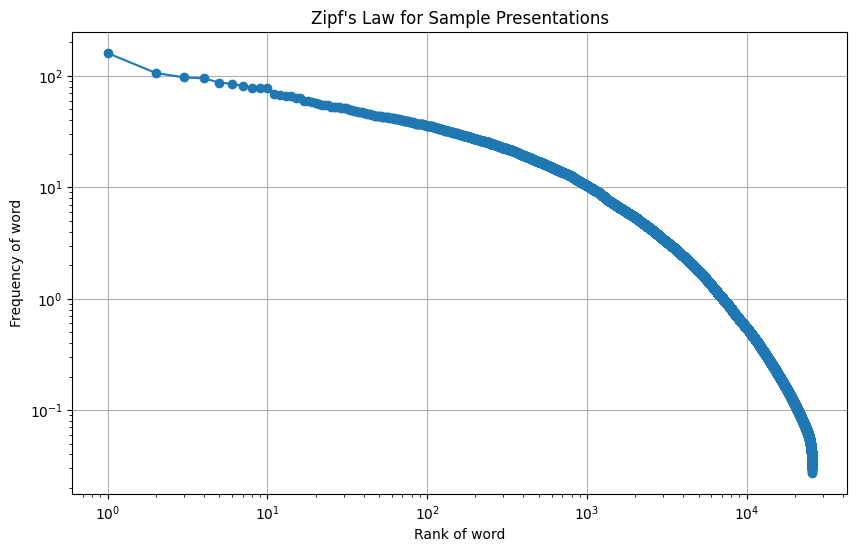

In [ ]:
# Zipf's law
import matplotlib.pyplot as plt


# Assuming dtm is a Pandas DataFrame with word frequencies
word_counts = presentation_tfidf_df.sum().sort_values(ascending=False)  # Sum frequencies and sort

# Convert to DataFrame for better handling
df_zipf = pd.DataFrame({'Word': word_counts.index, 'Frequency': word_counts.values})

# Add Rank
df_zipf['Rank'] = np.arange(1, len(df_zipf) + 1)

# Plot Zipf's Law
plt.figure(figsize=(10, 6))
plt.loglog(df_zipf['Rank'], df_zipf['Frequency'], marker='o')
plt.title("Zipf's Law for Sample Presentations")
plt.xlabel('Rank of word')
plt.ylabel('Frequency of word')
plt.grid(True)
plt.show()


In [ ]:
# Getting the top 10 terms with the highest TF-iDF across all documents
top_n = 20

# sum the TF-IDF value for each term across all documents
tfidf_sum = presentation_tfidf_df.sum()

# sort the terms by their TF-IDF sum in descending order
top_terms = tfidf_sum.nlargest(top_n)

# print
print("Top", top_n, "terms with highest TF-IDF across all documents:")
print(top_terms)

Top 20 terms with highest TF-IDF across all documents:
revenue      160.076656
q            106.232443
adjusted      96.985971
slide         95.065779
customers     87.092421
margin        84.849397
fiscal        81.246047
guidance      77.837056
fourth        77.738144
points        77.382484
segment       68.127323
flow          67.198239
tax           66.267223
income        65.849890
currency      63.580524
organic       63.115870
compared      59.314388
prior         59.236873
weve          57.912329
services      57.159331
dtype: float64


In [ ]:
# calculating cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(presentation_tfidf)
cosine_sim_matrix_df = pd.DataFrame(cosine_sim_matrix, columns=EC_presentations['file_name'], index=EC_presentations['file_name'])
cosine_sim_matrix_df.head()

file_name,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016/5594238_T.xml,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016/5594241_T.xml,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016/5594243_T.xml,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016/5756552_T.xml,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016/5756555_T.xml,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016/5765381_T.xml,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016/5765383_T.xml,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016/5765384_T.xml,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016/5776858_T.xml,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016/5776860_T.xml,...,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020/13478429_T.xml,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020/13498133_T.xml,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020/13498220_T.xml,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020/13501032_T.xml,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020/13501400_T.xml,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020/13506700_T.xml,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020/13522937_T.xml,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020/13539611_T.xml,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020/13545333_T.xml,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020/13546478_T.xml
file_name,,,,,,,,,,,,,,,,,,,,,
Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016/5594238_T.xml,1.000000,0.738352,0.779106,0.107560,0.104003,0.101170,0.116695,0.132463,0.123443,0.142949,...,0.057923,0.069509,0.078326,0.053868,0.075285,0.061472,0.058228,0.101486,0.065339,0.150566
Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016/5594241_T.xml,0.738352,1.000000,0.790695,0.111834,0.111184,0.094915,0.108988,0.109445,0.127343,0.152842,...,0.062302,0.071924,0.080155,0.059013,0.073927,0.066116,0.060514,0.091434,0.075459,0.134247
Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016/5594243_T.xml,0.779106,0.790695,1.000000,0.108602,0.110045,0.099513,0.116834,0.120469,0.133921,0.162281,...,0.058090,0.066738,0.083427,0.061376,0.078688,0.069794,0.064566,0.093497,0.077458,0.126277
Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016/5756552_T.xml,0.107560,0.111834,0.108602,1.000000,0.741035,0.069516,0.080058,0.078624,0.060816,0.072519,...,0.061463,0.124368,0.077161,0.042651,0.083067,0.071519,0.044654,0.069491,0.083248,0.083611
Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016/5756555_T.xml,0.104003,0.111184,0.110045,0.741035,1.000000,0.068213,0.073445,0.078246,0.060200,0.075939,...,0.051113,0.111278,0.069337,0.045956,0.079618,0.066895,0.043709,0.061664,0.075146,0.075735


# **The aim is to do a simple replication of the Firm-Level Political risk paper**

1.  **Download and import rescources**


*   Download Global risk reports from World Economic Forum from 2015-2021 to create geopolitical library.
*   Download financial accounting books from OpenStax to create non-geopolitical library. List sources:
*   Create and define risk dictonary using Cambridge Dictonary


2.   **Preprocess text**


*   Turn all text into lower case, remove punctation, special characteres and stopwords for all the libraries and earning calls
*   Create bigrams for each of the libaries and the Earning Calls presentation

3.   **Construct the measurment**



*   The measurment will be similar to the Firm-Level Poltical risk paper
*   Find bigrams that appear in the geopoltical library but not in the non-poltical library
*   Compute the score for each document

4.   **Performe regression**


*   Regress implied volatility on the geopolitical risk score, log of total assets, NUMEST and SurpDec while controlling for firm-fixed effects and time-fixed effects.
*   Regress capex/total_assets on geopoltical risk score, log of total assets and the book-to-market ratio


**1) Download and import Rescources**

In [ ]:
# create a preprocesser that could be used in the Santa Barbara Corupus
# This function will be used more under the preprocess section
def preprocessor_2(text):

    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [w for w in tokens if len(w) > 1]
    text = ' '.join(tokens)

    return text

In [ ]:
# links to drive: (they should be able to access for everyone with the link)
#https://drive.google.com/drive/folders/1LYAPOydE5TAwKpJpWKP3G7w1RZjdGy4h?usp=drive_link
#https://drive.google.com/drive/folders/1i1KQ8gLre3v8QAQrlKD9JjIPZhAHgufN?usp=drive_link
#https://drive.google.com/drive/folders/1xw7h-lkwpShA-5gw30DChZbvT5XI8WNe?usp=drive_link

# Access google drive
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# use pdfminer.six to make pdfs to text
from pdfminer.high_level import extract_text

# create paths for global risk reports from world economic forum
global_risk_report_WEF_2015             = '/content/drive/MyDrive/NLP_assignment_books_EDN/Global_risk_report_WEF_2015.pdf'
global_risk_report_WEF_2016             = '/content/drive/MyDrive/NLP_assignment_books_EDN/Global_risk_report_WEF_2016.pdf'
global_risk_report_WEF_2017             = '/content/drive/MyDrive/NLP_assignment_books_EDN/Global_risk_report_WEF_2017.pdf'
global_risk_report_WEF_2018             = '/content/drive/MyDrive/NLP_assignment_books_EDN/Global_risk_report_WEF_2018.pdf'
global_risk_report_WEF_2019             = '/content/drive/MyDrive/NLP_assignment_books_EDN/Global_risk_report_WEF_2019.pdf'
global_risk_report_WEF_2020             = '/content/drive/MyDrive/NLP_assignment_books_EDN/Global_risk_report_WEF_2020.pdf'
global_risk_report_WEF_2021             = '/content/drive/MyDrive/NLP_assignment_books_EDN/Global_risk_report_WEF_2021.pdf'

# Create path for global risk reports from Eurasia Group
Eurasia_group_2016                      = '/content/drive/MyDrive/NLP_assignment_books_EDN/1512_Top_Risks_2016.pdf'
Eurasia_group_2017                      = '/content/drive/MyDrive/NLP_assignment_books_EDN/Top_Risks_2017_Report.pdf'
Eurasia_group_2018                      = '/content/drive/MyDrive/NLP_assignment_books_EDN/Top_Risks_2018_Report.pdf'
Eurasia_group_2019                      = '/content/drive/MyDrive/NLP_assignment_books_EDN/Top_Risks_2019_Report.pdf'
Eurasia_group_2020                      = '/content/drive/MyDrive/NLP_assignment_books_EDN/Top_Risks_2020_Report_1.pdf'
Eurasia_group__covid_2020               = '/content/drive/MyDrive/NLP_assignment_books_EDN/top_risks_2020_coronavirus_edition_1.pdf'
Eurasia_group_2021                      = '/content/drive/MyDrive/NLP_assignment_books_EDN/top-risks-2021-full-report.pdf'

# Extract text for global risk reports
global_risk_report_WEF_2015             = extract_text(global_risk_report_WEF_2015)
global_risk_report_WEF_2016             = extract_text(global_risk_report_WEF_2016)
global_risk_report_WEF_2017             = extract_text(global_risk_report_WEF_2017)
global_risk_report_WEF_2018             = extract_text(global_risk_report_WEF_2018)
global_risk_report_WEF_2019             = extract_text(global_risk_report_WEF_2019)
global_risk_report_WEF_2020             = extract_text(global_risk_report_WEF_2020)
global_risk_report_WEF_2021             = extract_text(global_risk_report_WEF_2021)

Eurasia_group_2016                      = extract_text(Eurasia_group_2016)
Eurasia_group_2017                      = extract_text(Eurasia_group_2017)
Eurasia_group_2018                      = extract_text(Eurasia_group_2018)
Eurasia_group_2019                      = extract_text(Eurasia_group_2019)
Eurasia_group_2020                      = extract_text(Eurasia_group_2020)
Eurasia_group__covid_2020               = extract_text(Eurasia_group__covid_2020)
Eurasia_group_2021                      = extract_text(Eurasia_group_2021)


# create paths for finance books
tirole2006                              = '/content/drive/MyDrive/NLP_assignment_books_EDN/tirole2006.pdf'
FinancialAccounting                     = '/content/drive/MyDrive/NLP_assignment_books_EDN/FinancialAccounting.pdf'
ManagerialAccounting                    = '/content/drive/MyDrive/NLP_assignment_books_EDN/ManagerialAccounting-OP.pdf'


# Extract text for finance books
FinancialAccounting                     = extract_text(FinancialAccounting)
ManagerialAccounting                    = extract_text(ManagerialAccounting)


In [ ]:
# import the Santa Barbara Corpus
trn_folder = '/content/drive/MyDrive/SBCorpus_1'


# List all TRN files
trn_files = [f for f in os.listdir(trn_folder) if f.endswith('.trn')]

# List all TRN files
trn_files = [f for f in os.listdir(trn_folder) if f.endswith('.trn')]

# Read and parse files
data = []
for file in trn_files:
    file_path = os.path.join(trn_folder, file)
    with open(file_path, 'r', encoding='latin1') as f:
        content = f.read()
        lines = content.split('\n')
        for line in lines:
            if line.strip():
                # Match timestamp, speaker, and text using regex
                match = re.match(r'(\d+\.\d+)\t(\d+\.\d+)\t([A-Z]+):\t(.+)', line)
                if match:
                    start_time, end_time, speaker, text = match.groups()
                    # Clean text: remove brackets, overlaps, and special chars
                    cleaned_text = re.sub(r'\[.*?\]|\=|\.\.\.|\~', '', text).strip()
                    # Apply preprocessor_2 for consistency
                    cleaned_text = preprocessor_2(cleaned_text)
                    if cleaned_text:  # Ensure cleaned_text isn't empty
                        # Tokenize text
                        tokens = word_tokenize(cleaned_text)
                        data.append({
                            'file': file,
                            'start_time': float(start_time),
                            'end_time': float(end_time),
                            'speaker': speaker,
                            'raw_text': text,
                            'cleaned_text': cleaned_text,
                            'tokens': tokens
                        })

# Convert to DataFrame
SBCorpus = pd.DataFrame(data)

# make the SBcorupus into one single strin
SBCorpus_cleaned     = ' '.join(SBCorpus['cleaned_text'])
SBCorpus_cleaned

'hm even go ask tsk yeah well thats pretty much end creative people generally love yeah hm marketplace uh get get yeah hx uh right know heavens yes know know wish hunh didnt get diffe didnt hear followup thats thought long time oh oh thats yeah automatically sorts em right yeah yeah sample thank mister smith yeah personal computer representative thatd great push one know dinner want uh icial intelligence personality yeah vided charge allowed five personalities one phone call yeah matrixing thats right building top thoughts th predecessors predecessors like reflection brain think something define information yeah well superconductors mhm everybody tsk yeah yeah like know ky theyll able uh uh tsk thatll expensive first god space tsk well thats pretty frightening con frightening control freeways know mean well ciety familiar fractals unhunh yeah gy uh sci unhunh yeah totality taken account know made stone looking statue rubble bottom well oh know theyve got take ac account uh stars micros

In [ ]:
# take a look at the global risk reports
global_risk_report_WEF_2021[:10000]

'The Global Risks  \nReport 2021\n16th Edition\n\nI N S I G H T   R E P O R T\n\nIn partnership with Marsh McLennan, SK Group and Zurich Insurance Group\n\n\x0cThe Global Risks \nReport 2021\n16th Edition\n\nStrategic Partners\nMarsh McLennan\nSK Group\nZurich Insurance Group\n\nAcademic Advisers\nNational University of Singapore \nOxford Martin School, University of Oxford \nWharton Risk Management and Decision Processes Center, University of Pennsylvania \n\n\x0cThe Global Risks Report 2021, 16th Edition, \nis published by the World Economic Forum.\n\nThe information in this report, or on which \nthis report is based, has been obtained \nfrom sources that the authors believe \nto be reliable and accurate. However, it \nhas not been independently verified and \nno representation or warranty, express \nor implied, is made as to the accuracy \nor completeness of any information \nobtained from third parties. In addition, \nthe statements in this report may provide \ncurrent expectations

In [ ]:
# take a look at the finance books
FinancialAccounting[:10000]

'Volume 1\n\n\x0c\x0cPrinciples of Accounting, \nVolume 1: Financial \nAccounting \n\nSENIOR CONTRIBUTING AUTHORS \nMITCHELL FRANKLIN, LE MOYNE COLLEGE (FINANCIAL ACCOUNTING) \nPATTY GRAYBEAL, UNIVERSITY OF MICHIGAN-DEARBORN (MANAGERIAL ACCOUNTING) \nDIXON COOPER, OUACHITA BAPTIST UNIVERSITY \n\n\t\n\t\n \n \n \n \n \n \n \n \n \n \n \n \n \n\x0cOpenStax \nRice University \n6100 Main Street MS-375 \nHouston, Texas 77005 \n\nTo learn more about OpenStax, visit https://openstax.org. \nIndividual print copies and bulk orders can be purchased through our website. \n\n©2019 Rice University. Textbook content produced by OpenStax is licensed under a Creative Commons \nAttribution Non-Commercial ShareAlike 4.0 International License (CC BY-NC-SA 4.0). Under this license, any user \nof this textbook or the textbook contents herein can share, remix, and build upon the content for \nnoncommercial purposes only. Any adaptations must be shared under the same type of license. In any case of \nsharing

In [ ]:
Eurasia_group_2019[:10000]

'IAN BREMMER, PresidentCLIFF KUPCHAN, Chairman12345678910* -Bad seedsUS-ChinaCyber gloves offEuropean populismThe US at homeInnovation winterCoalition of the unwilling MexicoUkraineNigeriaBrexitRed herrings\x0cOverview\n\nIAN BREMMER, President\nCLIFF KUPCHAN, Chairman\n\nThe geopolitical environment is the most dangerous it’s been in decades ... and at a moment \nwhen the global economy is faring well. Markets are increasingly volatile but resilient, taking hits \nbut mostly bouncing back. What’s wrong with this picture? \n\nNothing … yet. Geopolitical cycles are slow-moving. It takes a long time to build a geopolitical or-\nder; governments change course through the workings of complex institutions, coalition politics, \nelection cycles, and checks and balances. Multilateral institutions take decades to build, and they \ngain momentum slowly. Norms and values need to develop, to become accepted, and to shape \ninstitutions and societies over time. Once in place, they’re sticky. And s

**2.1) Preprocess texts and create libaries**

In [ ]:
# preprocess the presenation and QA
EC_presentations['presentation_cleaned'] = EC_presentations['presentation'].apply(preprocessor_2)
EC_answers['Answers_cleaned']            = EC_answers['QA_text'].apply(preprocessor_2)
EC_presentations['presentation_cleaned'].head()

,presentation_cleaned
0,ladies gentlemen thank standing welcome first ...
1,welcome prudential quarterly earnings call ope...
2,ladies gentlemen thank standing welcome pruden...
3,ladies gentlemen thank standing welcome earnin...
4,ladies gentlemen thank standing welcome earnin...


In [ ]:
# preprocess the geopolitical library
global_risk_report_WEF_2015_cleaned     = preprocessor_2(global_risk_report_WEF_2015)
global_risk_report_WEF_2016_cleaned     = preprocessor_2(global_risk_report_WEF_2016)
global_risk_report_WEF_2017_cleaned     = preprocessor_2(global_risk_report_WEF_2017)
global_risk_report_WEF_2018_cleaned     = preprocessor_2(global_risk_report_WEF_2018)
global_risk_report_WEF_2019_cleaned     = preprocessor_2(global_risk_report_WEF_2019)
global_risk_report_WEF_2020_cleaned     = preprocessor_2(global_risk_report_WEF_2020)
global_risk_report_WEF_2021_cleaned     = preprocessor_2(global_risk_report_WEF_2021)

Eurasia_group_2016_cleaned              = preprocessor_2(Eurasia_group_2016)
Eurasia_group_2017_cleaned              = preprocessor_2(Eurasia_group_2017)
Eurasia_group_2018_cleaned              = preprocessor_2(Eurasia_group_2018)
Eurasia_group_2019_cleaned              = preprocessor_2(Eurasia_group_2019)
Eurasia_group_2020_cleaned              = preprocessor_2(Eurasia_group_2020)
Eurasia_group__covid_2020_cleaned       = preprocessor_2(Eurasia_group__covid_2020)
Eurasia_group_2021_cleaned              = preprocessor_2(Eurasia_group_2021)

# gather the geopolitical texts
preprocessed_geopolitical_texts = [
    global_risk_report_WEF_2015_cleaned,
    global_risk_report_WEF_2016_cleaned,
    global_risk_report_WEF_2017_cleaned,
    global_risk_report_WEF_2018_cleaned,
    global_risk_report_WEF_2019_cleaned,
    global_risk_report_WEF_2020_cleaned,
    global_risk_report_WEF_2021_cleaned,
    Eurasia_group_2016_cleaned,
    Eurasia_group_2017_cleaned,
    Eurasia_group_2018_cleaned,
    Eurasia_group_2019_cleaned,
    Eurasia_group_2020_cleaned,
    Eurasia_group__covid_2020_cleaned,
    Eurasia_group_2021_cleaned
]

In [ ]:
# take a look
preprocessed_geopolitical_texts[0][:10000]

'insight report global risks th edition global risks th edition published world economic forum within framework global competitiveness benchmarking network information report report based obtained sources authors believe reliable accurate however independently verified representation warranty express implied made accuracy completeness information obtained third parties addition statements report may provide current expectations future events based certain assumptions may include statements directly relate historical current fact statements involve known unknown risks uncertainties factors exhaustive readers cautioned place undue reliance statements companies contributing report undertake obligation publicly revise update statements whether result new information future events otherwise shall event liable loss damage arising connection use information report world economic forum geneva world economic forum rights reserved part publication may reproduced transmitted form means including 

In [ ]:
# preprocess the finanical accounting texts
FinancialAccounting_cleaned              = preprocessor_2(FinancialAccounting)
ManagerialAccounting_cleaned             = preprocessor_2(ManagerialAccounting)

# gather the non geopoltical texts
preprocessed_nongeopolitical_texts = [
    FinancialAccounting_cleaned,
    ManagerialAccounting_cleaned
]


In [ ]:
# take a look
preprocessed_nongeopolitical_texts[0][:10000]

'volume principles accounting volume financial accounting senior contributing authors mitchell franklin le moyne college financial accounting patty graybeal university michigandearborn managerial accounting dixon cooper ouachita baptist university openstax rice university main street ms houston texas learn openstax visit httpsopenstaxorg individual print copies bulk orders purchased website rice university textbook content produced openstax licensed creative commons attribution noncommercial sharealike international license cc byncsa license user textbook textbook contents herein share remix build upon content noncommercial purposes adaptations must shared type license case sharing original adapted material whether whole part user must provide proper attribution follows noncommercially redistribute textbook digital format including limited pdf html must retain every page following attribution download free httpsopenstaxorgdetailsbooksprinciplesfinancialaccounting noncommercially redist

In [ ]:
# Define risk/uncertainity dictonariy
risk_synonyms = {
    "risk",
    "risks",
    "risky",
    "uncertain",
    "uncertainty",
    "uncertainties",
    "uncertainly",
    "hazard",
    "hazards",
    "threat",
    "threats",
    "danger",
    "dangers",
    "peril",
    "perils",
}


**2.2) Create bigrams**

In [ ]:
# create bigrams function
from nltk import bigrams
def build_bigrams(doc):

    text         = doc.lower()
    text         = re.sub(r'[^a-z\s]', '', text)
    tokens       = word_tokenize(text)
    stop_words   = set(stopwords.words('english'))
    tokens       = [w for w in tokens if w not in stop_words]
    tokens       = [w for w in tokens if len(w) > 1]
    pos_tags     = nltk.pos_tag(tokens)
    pronoun_tags = {'PRP', 'PRP$', 'WP', 'WP$'}
    adverb_tags = {'RB', 'RBR', 'RBS', 'WRB'}
    filtered_tokens = [
        token for token, pos in pos_tags
        if pos not in pronoun_tags and pos not in adverb_tags
    ]

    bigram_iter = bigrams(filtered_tokens)
    bigram_list = list(bigram_iter)

    return bigram_list

In [ ]:
# apply the function
EC_presentations['presentation_bigrams'] = EC_presentations['presentation_cleaned'].swifter.apply(build_bigrams)
EC_answers['Answers_bigram']             = EC_answers['Answers_cleaned'].swifter.apply(build_bigrams)

# print the answer
print("Earnings Calls - Presentations:")
print(EC_presentations[['presentation_cleaned', 'presentation_bigrams']].head())
print("\nEarnings Calls - Answers:")
print(EC_answers[['Answers_cleaned', 'Answers_bigram']].head())

Pandas Apply:   0%|          | 0/2877 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2877 [00:00<?, ?it/s]

In [ ]:
# create functions to build bigram for each library and count the frequency of each bigram in each library
from collections import Counter

def build_bigram_library(text_lists):

    bigram_counter = Counter()

    for doc in text_lists:
        bigrams = build_bigrams(doc)
        bigram_counter.update(bigrams)

    return bigram_counter

In [ ]:
# apply the function
geopolitics_bigrams         = build_bigram_library(preprocessed_geopolitical_texts)
non_geopolitical_bigrams    = build_bigram_library(preprocessed_nongeopolitical_texts)

In [ ]:
# look at the most common bigrams in the political library
geopolitics_bigrams.most_common(100)

In [ ]:
non_geopolitical_bigrams.most_common(100)

In [ ]:
# manually exclude some irrelevant bigrams
bigrams_to_exclude = [
    # From geopolitics_bigrams
    ("report", "part"),
    ("see", "figure"),
    ("et", "al"),
    ("op", "cit"),
    ("idea", "cid"),
    ("risks", "perception"),
    ("perception", "survey"),
    ("respondents", "asked"),
    ("risks", "landscape"),
    ("world", "economic"),
    ("economic", "forum"),
    ("forum", "global"),
    ("eurasia", "group"),
    ("group", "top"),
    ("zurich", "insurance"),
    ("insurance", "group"),
    ("marsh", "mclennan"),
    ("world", "bank"),
    ("united", "nations"),
    ("new", "york"),
    ("washington", "dc"),
    ("next", "years"),
    ("many", "countries"),
    ("major", "economy"),
    # From non_geopolitical_bigrams
    ("free", "httpcnxorgcontentcol"),
    ("httpcnxorgcontentcol", "chapter"),
    ("attribution", "copyright"),
    ("copyright", "rice"),
    ("openstax", "cc"),
    ("cc", "byncsa"),
    ("byncsa", "license"),
    ("chapter", "accounting"),
    ("openstax", "book"),
    ("book", "available"),
    ("available", "free"),
    ("university", "openstax"),
    ("rice", "university"),
    ("following", "transactions")
]

In [ ]:
# filtering out specified bigrams
filtered_geopolitics_bigrams      = Counter({bigram: freq for bigram, freq in geopolitics_bigrams.items()
                                        if bigram not in bigrams_to_exclude})
filtered_non_geopolitical_bigrams = Counter({bigram: freq for bigram, freq in non_geopolitical_bigrams.items()
                                             if bigram not in bigrams_to_exclude})

In [ ]:
filtered_geopolitics_bigrams.most_common(50)

In [ ]:
filtered_non_geopolitical_bigrams.most_common(50)

**3.0) Identify G/N and Compute Weights**


*   More spefically, identify the bigrams that appear in the geopoltical library (G) but not in the non geopoltical library (N)



In [ ]:
# identify the bigrams that appear in the geopolitical library, but not in the non-geopolitical library
# and calculate weights

bigram_G_not_N = {}

total_bigrams_g = sum(filtered_geopolitics_bigrams.values())

for bigram, freq in filtered_geopolitics_bigrams.items():
    if bigram not in filtered_non_geopolitical_bigrams:
        # Weight is the frequency in the geopolitical library divided by total bigrams in G
        bigram_G_not_N[bigram] = freq / total_bigrams_g

print("Bigrams in G but not N:", len(bigram_G_not_N))

In [ ]:
# check out the most common bigrams that are in geo library, but not non-geo library
#bigram_G_not_N

**3.1) Calculate the geopoltical risk score**


*   The idea here is to look for bigrams from P/N meaning bigrams that are in geopoltical library but not in geopoltical library and that are withing +- 10 words of a risk/uncertinaity synonym in each document.

Here we create three functions. One for calculating the geopoltiical risk score, one for cal



In [ ]:
def compute_geopolitical_risk_score(
    df,
    text_col,
    bigrams_col,
    bigram_dict,
    risk_synonyms,
    window=10,
    scale_factor=1_000_000
):
    """
    Compute a 'geopolitics_risk_score' for each row in the DataFrame.

    Steps:
      1. Skip rows where text is non-string or the bigram list is missing/invalid.
      2. For each row, reconstruct the token list from the bigrams.
      3. Identify positions of risk words in the tokens.
      4. For each bigram in 'bigram_dict':
         - Check if it’s within 'window' distance of a risk word's position.
         - If yes, add 'bigram_dict[bigram]' to a running sum.
      5. Final score = (sum of weights / # of bigrams) * scale_factor
      6. Store in a new column 'geopolitics_risk_score'.

    Args:
        df (pd.DataFrame): The DataFrame containing transcripts or texts.
        text_col (str): Column name for the cleaned text (optional check).
        bigrams_col (str): Column name for the bigram list (e.g. [("token1","token2"), ...]).
        bigram_dict (dict): Dictionary mapping bigrams -> float weight (freq in geo library).
        risk_synonyms (set): Set of risk-related words (lowercase).
        window (int): # of tokens around a risk word to consider a bigram "close".
        scale_factor (float): Multiply scores by this factor to get bigger numbers (optional).

    Returns:
        pd.DataFrame: The input DataFrame with a new 'geopolitics_risk_score' column.
    """

    def reconstruct_tokens_from_bigrams(bigrams_list):
        """Rebuild a token sequence from the list of consecutive bigrams."""
        if not bigrams_list:
            return []
        # start with the first word of the first bigram
        tokens_out = [bigrams_list[0][0]]
        # then append the second word of each bigram
        for bg in bigrams_list:
            tokens_out.append(bg[1])
        return tokens_out

    scores = []

    for idx in range(len(df)):
        row = df.iloc[idx]

        # Basic sanity checks for text & bigrams columns
        if (text_col not in row) or (not isinstance(row[text_col], str)) or (not row[text_col].strip()):
            scores.append(0.0)
            continue
        if (bigrams_col not in row) or (not isinstance(row[bigrams_col], list)) or (not row[bigrams_col]):
            scores.append(0.0)
            continue

        # Reconstruct tokens from the row's bigrams
        bigrams_list = row[bigrams_col]
        tokens = reconstruct_tokens_from_bigrams(bigrams_list)
        if not tokens:
            scores.append(0.0)
            continue

        # Identify positions of risk-related words in tokens
        risk_positions = [i for i, word in enumerate(tokens) if word in risk_synonyms]
        if not risk_positions:
            # no risk words => 0.0
            scores.append(0.0)
            continue

        # Calculate the sum of matched bigram weights near risk words
        score_sum = 0.0
        for bg_idx, bg in enumerate(bigrams_list):
            if bg in bigram_dict:
                # bigram covers positions (bg_idx, bg_idx+1)
                # check if it's within 'window' of a risk word
                is_near_risk = any(
                    min(abs(bg_idx - rp), abs(bg_idx + 1 - rp)) <= window
                    for rp in risk_positions
                )
                if is_near_risk:
                    score_sum += bigram_dict[bg]

        # final score scaled by total # of bigrams
        final_score = 0.0
        if len(bigrams_list) > 0:
            final_score = (score_sum / len(bigrams_list)) * scale_factor

        scores.append(final_score)

    df['geopolitics_risk_score'] = scores
    return df


In [ ]:
# apply the function
EC_presentations = compute_geopolitical_risk_score(
    df=EC_presentations,
    text_col='presentation_cleaned',
    bigrams_col='presentation_bigrams',
    bigram_dict=bigram_G_not_N,
    risk_synonyms=risk_synonyms,
    window=10,
    scale_factor=1_000_000
)


# Apply the scoring to Q&A answers
EC_answers = compute_geopolitical_risk_score(
    df = EC_answers,
    text_col='Answers_cleaned',
    bigrams_col='Answers_bigram',
    bigram_dict=bigram_G_not_N,
    risk_synonyms=risk_synonyms,
    window=10,
    scale_factor=1_000_000
)

# Print summary statistics
print("\nSummary Statistics for Presentations:")
print(EC_presentations['geopolitics_risk_score'].describe())
print(f"Number of non-zero scores: {(EC_presentations['geopolitics_risk_score'] > 0).sum()}")

print("\nSummary Statistics for Q&A Answers:")
print(EC_answers['geopolitics_risk_score'].describe())
print(f"Number of non-zero scores: {(EC_answers['geopolitics_risk_score'] > 0).sum()}")

In [ ]:
# calculate the number of non-zero scores to total count
non_zero_presentations            = (EC_presentations['geopolitics_risk_score'] > 0).sum()
total_presentations               = len(EC_presentations)
percentage_non_zero_presentations = (non_zero_presentations / total_presentations) * 100

non_zero_answers                  = (EC_answers['geopolitics_risk_score'] > 0).sum()
total_answers                     = len(EC_answers)
percentage_non_zero_answers       = (non_zero_answers / total_answers) * 100

print(f"Percentage of non-zero scores in presentations: {percentage_non_zero_presentations:.2f}%")
print(f"Percentage of non-zero scores in answers: {percentage_non_zero_answers:.2f}%")

In [ ]:
# remove outliers
clip_val_presentations                            = EC_presentations['geopolitics_risk_score'].quantile(0.99)
clip_val_answers                                  = EC_answers['geopolitics_risk_score'].quantile(0.99)

EC_presentations['geopolitics_risk_score_no_out'] = EC_presentations['geopolitics_risk_score'].clip(upper=clip_val_presentations)
EC_answers['geopolitics_risk_score_no_out']       = EC_answers['geopolitics_risk_score'].clip(upper=clip_val_answers)

scaler_presentation = StandardScaler()
scaler_answers      = StandardScaler()

EC_presentations['geopolitics_risk_score_standardized'] = scaler_presentation.fit_transform(EC_presentations[['geopolitics_risk_score_no_out']])
EC_answers['geopolitics_risk_score_standardized']       = scaler_answers.fit_transform(EC_answers[['geopolitics_risk_score_no_out']])



top_gp_risk_presentation = EC_presentations.sort_values(by='geopolitics_risk_score_standardized', ascending=False).head(10)
top_gp_risk_answers      = EC_answers.sort_values(by='geopolitics_risk_score_standardized', ascending=False).head(10)

print(top_gp_risk_presentation[['co_conm', 'geopolitics_risk_score_standardized']])
print(top_gp_risk_answers[['co_conm', 'geopolitics_risk_score_standardized']])


In [ ]:
# group qaurter and compute the mean score for plotting
quarterly_risk_presentation = EC_presentations.groupby('quarter')['geopolitics_risk_score_standardized'].mean().reset_index()
quarterly_risk_answers      = EC_answers.groupby('quarter')['geopolitics_risk_score_standardized'].mean().reset_index()

print(quarterly_risk_presentation.head())
print(quarterly_risk_answers.head())


In [ ]:
# Set a Seaborn style for a more modern look
import seaborn as sns
sns.set(style="whitegrid", context="talk", palette="muted")

# Convert 'quarter' column to datetime for both DataFrames
quarterly_risk_presentation['quarter_dt'] = pd.to_datetime(quarterly_risk_presentation['quarter'].astype(str))
quarterly_risk_answers['quarter_dt'] = pd.to_datetime(quarterly_risk_answers['quarter'].astype(str))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the mean standardized risk score for presentations
ax.plot(quarterly_risk_presentation['quarter_dt'],
        quarterly_risk_presentation['geopolitics_risk_score_standardized'],
        marker='o', markersize=8, linewidth=2, color='steelblue',
        label='Presentations Geopolitical Risk')

# Plot the mean standardized risk score for answers
ax.plot(quarterly_risk_answers['quarter_dt'],
        quarterly_risk_answers['geopolitics_risk_score_standardized'],
        marker='s', markersize=8, linewidth=2, color='darkorange',
        label='Q&A Answers Geopolitical Risk')

# Highlight the area under the curves (optional)
ax.fill_between(quarterly_risk_presentation['quarter_dt'],
                quarterly_risk_presentation['geopolitics_risk_score_standardized'],
                color='steelblue', alpha=0.1)
ax.fill_between(quarterly_risk_answers['quarter_dt'],
                quarterly_risk_answers['geopolitics_risk_score_standardized'],
                color='darkorange', alpha=0.1)

# Define major events with dates and labels
events = {
    '2016-11-08': '2016 US Election',
    '2017-03-06': 'North Korea Missile Test',
    '2017-03-29': 'Brexit Article 50',
    '2018-01-20': 'Gov Shutdown Start',
    '2018-03-01': 'Tariff Announcement',
    '2020-03-11': 'COVID-19 Declared',
    '2020-11-03': '2020 US Election'
}

# Add vertical lines and annotations for events
for event_date, label in events.items():
    d = pd.to_datetime(event_date)
    ax.axvline(d, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
    ax.text(d, ax.get_ylim()[1]*0.95, label, rotation=90, verticalalignment='top',
            horizontalalignment='right', fontsize=12, color='red', backgroundcolor='w', alpha=0.8)

# Improve the x-axis formatting
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Mean Standardized Geopolitical Risk Score', fontsize=14)
ax.set_title('Evolution of Geopolitical Risk Over Time (Presentations vs Q&A Answers)', fontsize=18, weight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=45)

# Add a legend
ax.legend(fontsize=14, loc='upper left')

# Add a grid
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate average risk score for each company
company_avg_presentations = (
    EC_presentations
    .groupby('co_conm')['geopolitics_risk_score_standardized']
    .mean()
    .reset_index(name='avg_risk')
)

# Sort companies by their average risk
company_avg_sorted_presentations = company_avg_presentations.sort_values('avg_risk')
# The 10 companies with the lowest average risk
lowest_10 = company_avg_presentations.head(5)['co_conm'].tolist()
# The 10 companies with the highest average risk
highest_10 = company_avg_presentations.tail(5)['co_conm'].tolist()

print("Lowest 10 average risk companies:", lowest_10)
print("Highest 10 average risk companies:", highest_10)

In [ ]:
# Calculate average risk score for each company using Q&A answers
company_avg_answers = (
    EC_answers
    .groupby('co_conm')['geopolitics_risk_score_standardized']
    .mean()
    .reset_index(name='avg_risk')
)

# Sort companies by their average risk
company_avg_sorted_answers = company_avg_answers.sort_values('avg_risk')

# The 5 companies with the lowest average risk (Q&A answers)
lowest_10_answers = company_avg_sorted_answers.head(5)['co_conm'].tolist()

# The 5 companies with the highest average risk (Q&A answers)
highest_10_answers = company_avg_sorted_answers.tail(5)['co_conm'].tolist()

# Print the results
print("Lowest 5 average risk companies (Q&A Answers):", lowest_10_answers)
print("Highest 5 average risk companies (Q&A Answers):", highest_10_answers)

**4) Regression**

In [ ]:
# calculate log of total assets, calculate B/M ratio, calculate Capex/total assets, calcualte long-term debt to total assets for presentations
EC_presentations['log_atq']          = np.log(EC_presentations['atq'] + 1)
EC_presentations['market_cap']       = EC_presentations['prccq'] * EC_presentations['cshoq']
EC_presentations['book_to_market']   = EC_presentations['ceqq'] / EC_presentations['market_cap']
EC_presentations['lt_debt_to_at']    = EC_presentations['dlttq'] / EC_presentations['atq']


# calculate Capex/total assets, and lag total assets by one period for presentations
EC_presentations['lag_atq']          = EC_presentations.groupby('GVKEY')['atq'].shift(1)
EC_presentations['capex_to_at']      = EC_presentations['capxy'] / EC_presentations['lag_atq']

# calculate log of total assets, calculate B/M ratio, calcualte long-term debt to total assets for answers
EC_answers['log_atq']                 = np.log(EC_answers['atq'] + 1)
EC_answers['market_cap']              = EC_answers['prccq'] * EC_answers['cshoq']
EC_answers['book_to_market']          = EC_answers['ceqq'] / EC_answers['market_cap']
EC_answers['lt_debt_to_at']           = EC_answers['dlttq'] / EC_answers['atq']

# calculate Capex/total assets, and lag total assets by one period for answers
EC_answers['lag_atq']                = EC_answers.groupby('GVKEY')['atq'].shift(1)
EC_answers['capex_to_at']            = EC_answers['capxy'] / EC_answers['lag_atq']

# rename troubled column names
EC_presentations['CAR_11_Carhart']    = EC_presentations['CAR-11-Carhart']
EC_answers['CAR_11_Carhart']          = EC_answers['CAR-11-Carhart']

# drop NAs in implied vol
EC_presentations_clean_IV                = EC_presentations.dropna(subset=['IV']).reset_index(drop=True)
EC_answers_clean_IV                      = EC_answers.dropna(subset=['IV']).reset_index(drop=True)

# drop NAs in capex_to_at
EC_presentations_clean_capex                = EC_presentations.dropna(subset=['capex_to_at']).reset_index(drop=True)
EC_answers_clean_capex                      = EC_answers.dropna(subset=['capex_to_at']).reset_index(drop=True)

# Ensure quarter is a string for fixed effects
EC_presentations_clean_IV['quarter_str']    = EC_presentations_clean_IV['quarter'].astype(str)
EC_answers_clean_IV['quarter_str']          = EC_answers_clean_IV['quarter'].astype(str)
EC_presentations_clean_capex['quarter_str'] = EC_presentations_clean_capex['quarter'].astype(str)
EC_answers_clean_capex['quarter_str']       = EC_answers_clean_capex['quarter'].astype(str)

# Convert GVKEY to numeric codes for clustering
EC_presentations_clean_IV['GVKEY_int']    = EC_presentations_clean_IV['GVKEY'].astype('category').cat.codes
EC_answers_clean_IV['GVKEY_int']          = EC_answers_clean_IV['GVKEY'].astype('category').cat.codes
EC_presentations_clean_capex['GVKEY_int'] = EC_presentations_clean_capex['GVKEY'].astype('category').cat.codes
EC_answers_clean_capex['GVKEY_int']       = EC_answers_clean_capex['GVKEY'].astype('category').cat.codes


print("Cleaned observations:", len(EC_presentations_clean_IV))
print("Columns:", EC_presentations_clean_IV.columns)




In [ ]:
# regress the implied volatility on the GRisk Score and log of total assets while controlling for firm and time-fixed effects
model_iv_pres = smf.ols(
    formula="IV ~ geopolitics_risk_score_standardized + log_atq + NUMEST + SurpDec + C(GVKEY_int) + C(quarter_str)",
    data=EC_presentations_clean_IV
).fit(cov_type='cluster', cov_kwds={'groups': EC_presentations_clean_IV['GVKEY_int']})

print(model_iv_pres.summary())


In [ ]:
# regress the implied volatility on the GRisk Score and log of total assets while controlling for firm and time-fixed effects
model_iv_answers = smf.ols(
    formula="IV ~ geopolitics_risk_score_standardized + log_atq + NUMEST + SurpDec + C(GVKEY_int) + C(quarter_str)",
    data=EC_answers_clean_IV
).fit(cov_type='cluster', cov_kwds={'groups': EC_answers_clean_IV['GVKEY_int']})

print(model_iv_answers.summary())

In [ ]:
# regress the historical volatilty on
model_inv_pres = smf.ols(
    formula="capex_to_at ~ geopolitics_risk_score_standardized + log_atq + book_to_market + C(GVKEY_int) + C(quarter_str)",
    data=EC_presentations_clean_capex
).fit(cov_type='cluster', cov_kwds={'groups': EC_presentations_clean_capex['GVKEY_int']})

print(model_inv_pres.summary())

In [ ]:
# regress the historical volatility on the GeoRisk Score while controlling for firm size and firm and time fixed-effects
model_inv_answers = smf.ols(
    formula="capex_to_at ~ geopolitics_risk_score_standardized + log_atq + book_to_market + C(GVKEY_int) + C(quarter_str)",
    data=EC_answers_clean_capex
).fit(cov_type='cluster', cov_kwds={'groups': EC_answers_clean_capex['GVKEY_int']})

print(model_inv_answers.summary())